In [1]:
import os
import random
import sys

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from alibi_detect.cd import MMDDrift
import random

sys.path.append("..")

from utils.utils import *
from baseline_models.temporal.pytorch.optimizer import Optimizer
from baseline_models.temporal.pytorch.utils import *

2022-06-28 16:05:54,264 INFO cyclops.orm     - Database setup, ready to run queries!


In [2]:
hospital = ["SBK", "UHNTG", "THPC", "THPM", "UHNTW", "SMH","MSH"]
dataset="all"
BASE_DATA_PATH = "/mnt/nfs/project/delirium/drift_exp/risk_of_mortality"

In [3]:
(x_train, y_train), (x_val, y_val), (x_test, y_test), feats, orig_dims, admin_data = import_dataset_hospital(BASE_DATA_PATH, dataset, hospital, shuffle=True)

2022-06-28 16:05:54,304 INFO cyclops.utils.file - Loading dataframe to /mnt/nfs/project/delirium/drift_exp/risk_of_mortality/aggregated_events.parquet


Load data from aggregated events...


2022-06-28 16:05:54,561 INFO cyclops.utils.file - Loading dataframe to /mnt/nfs/project/delirium/drift_exp/risk_of_mortality/aggmeta_start_ts.parquet
2022-06-28 16:05:54,652 INFO cyclops.feature_handler - Loading features from file...
2022-06-28 16:05:54,654 INFO cyclops.feature_handler - Found file to load for static features...
2022-06-28 16:05:54,655 INFO cyclops.feature_handler - Successfully loaded static features from file...
2022-06-28 16:05:54,679 INFO cyclops.feature_handler - Found file to load for temporal features...


Load data from feature handler...


2022-06-28 16:05:57,422 INFO cyclops.feature_handler - Successfully loaded temporal features from file...


Load data from admin data...


2022-06-28 16:06:01,245 INFO cyclops.utils.file - Loading dataframe to /mnt/nfs/project/delirium/drift_exp/risk_of_mortality/aggmeta_end_ts.parquet


In [4]:
feature_handler = FeatureHandler()
feature_handler.load(BASE_DATA_PATH, "features")

# Get types of columns
numerical_cols = feature_handler.get_numerical_feature_names()["temporal"]
numerical_cols += ["age"]

x_train_normalized = x_train.copy()
x_val_normalized = x_val.copy()
x_test_normalized = x_test.copy()

for col in numerical_cols:
    scaler = StandardScaler().fit(x_train[col].values.reshape(-1, 1))
    x_train_normalized[col] = pd.Series(
        np.squeeze(scaler.transform(x_train[col].values.reshape(-1, 1))),
        index=x_train[col].index,
    )
    x_val_normalized[col] = pd.Series(
        np.squeeze(scaler.transform(x_val[col].values.reshape(-1, 1))),
        index=x_val[col].index,
    )
    x_test_normalized[col] = pd.Series(
        np.squeeze(scaler.transform(x_test[col].values.reshape(-1, 1))),
        index=x_test[col].index,
    )

OUT_DATA_PATH = "/mnt/nfs/project/delirium/drift_exp/datasets"
os.makedirs(os.path.join(OUT_DATA_PATH, dataset), exist_ok=True)

x_train_normalized.to_parquet(
    os.path.join(OUT_DATA_PATH, dataset, "x_train.parquet")
)
x_val_normalized.to_parquet(os.path.join(OUT_DATA_PATH, dataset, "x_val.parquet"))
x_test_normalized.to_parquet(os.path.join(OUT_DATA_PATH, dataset, "x_test.parquet"))

np.save(os.path.join(OUT_DATA_PATH, dataset, "y_train.npy"), y_train)
np.save(os.path.join(OUT_DATA_PATH, dataset, "y_val.npy"), y_val)
np.save(os.path.join(OUT_DATA_PATH, dataset, "y_test.npy"), y_test)

2022-06-28 16:13:20,735 INFO cyclops.feature_handler - Loading features from file...
2022-06-28 16:13:20,737 INFO cyclops.feature_handler - Found file to load for static features...
2022-06-28 16:13:20,738 INFO cyclops.feature_handler - Successfully loaded static features from file...
2022-06-28 16:13:20,764 INFO cyclops.feature_handler - Found file to load for temporal features...
2022-06-28 16:13:23,365 INFO cyclops.feature_handler - Successfully loaded temporal features from file...


## Create Data Streams

In [5]:
from datetime import date, timedelta

#####################################################
## a given date contains data from previous two weeks 
#####################################################

start_date = date(2018, 1, 1)
end_date = date(2020, 8, 1)

def daterange(start_date, end_date, stride, window):
    for n in range(int((end_date - start_date).days)):
        if start_date + timedelta(n*stride+window) < end_date:
            yield start_date+ timedelta(n*stride)
            

def get_streams(x, y, admin_data, start_date, end_date, stride, window):
    target_stream_x = []
    target_stream_y = [] 
    measure_dates = []

    admit_df = admin_data[[ENCOUNTER_ID,ADMIT_TIMESTAMP]].sort_values(by=ADMIT_TIMESTAMP)
    for single_date in daterange(start_date, end_date, stride, window):
        if single_date.month ==1 and single_date.day == 1:
            print(single_date.strftime("%Y-%m-%d"),"-",(single_date+timedelta(days=window)).strftime("%Y-%m-%d"))
        encounters_inwindow = admit_df.loc[((single_date+timedelta(days=window)).strftime("%Y-%m-%d") > admit_df[ADMIT_TIMESTAMP].dt.strftime("%Y-%m-%d")) 
                           & (admit_df[ADMIT_TIMESTAMP].dt.strftime("%Y-%m-%d") >= single_date.strftime("%Y-%m-%d")), ENCOUNTER_ID].unique()
        encounter_ids = x.index.get_level_values(0).unique()
        x_inwindow = x.loc[x.index.get_level_values(0).isin(encounters_inwindow)]
        y_inwindow = y[np.in1d(encounter_ids, encounters_inwindow)]
        if not x_inwindow.empty:
            target_stream_x.append(x_inwindow)
            target_stream_y.append(y_inwindow)
            measure_dates.append((single_date+timedelta(days=window)).strftime("%Y-%m-%d"))
    return(target_stream_x, target_stream_y, measure_dates)

x_test_stream, y_test_stream, measure_dates_test = get_streams(x_test_normalized, y_test, admin_data, start_date, end_date, stride=1, window=1)

2018-01-01 - 2018-01-02
2019-01-01 - 2019-01-02
2020-01-01 - 2020-01-02


## Dynamic Rolling Window

In [31]:
threshold = 0.05
num_timesteps = 6
stat_window=14
lookup_window=14
stride=1
random.seed(1)
#####################################################
## dynamically adjusting drift detector - if drift is significant, reference dataset is reset to current time 
#####################################################
def dynamic_rolling_window(stat_window, lookup_window, stride, num_timesteps, series, threshold,custom_ref=None):

    p_vals = np.asarray([])
    dist_vals = np.asarray([])
    run_length = int(stat_window) 
    
    i = stat_window
    
    if custom_ref is not None:
        prev = reshape_inputs(custom_ref, num_timesteps)
    
    while i+stat_window+lookup_window <= len(series):
        feat_index = 0
        
        if custom_ref is None:
            prev = pd.concat(series[max(int(i)-run_length,0):int(i)+stat_window])
            prev = prev[~prev.index.duplicated(keep='first')]
            prev = reshape_inputs(prev, num_timesteps)
            #prev = prev.reshape(prev.shape[0]*prev.shape[1],prev.shape[2])
            
        next = pd.concat(series[max(int(i)+lookup_window,0):int(i)+stat_window+lookup_window])
        next = next[~next.index.duplicated(keep='first')]
        next = reshape_inputs(next, num_timesteps)
        #next = next.reshape(next.shape[0]*next.shape[1],next.shape[2])
        if next.shape[0]<=2 or prev.shape[0]<=2:
            break
            
        ## run distribution shift check here
        cd = MMDDrift(prev, backend='pytorch', p_val=.05)
        preds = cd.predict(next, return_p_val=True, return_distance=True)
        p_val = preds['data']['p_val']
        dist_val = preds['data']['distance']

        #print(max(int(i)-run_length,0),"-", int(i),"-->",max(int(i)+lookup_window,0),"-",int(i)+stat_window+lookup_window,"\tP-Value: ",p_val)
        
        #####################################
        if p_val >= threshold:
            dist_vals = np.concatenate((dist_vals, np.repeat(dist_val, 1)))
            p_vals = np.concatenate((p_vals, np.repeat(p_val, 1)))
            i += stride
            run_length += stride
        else:
            print("P-value below threshold, reset.")
            print(max(int(i)-run_length,0),"-", int(i),"-->",max(int(i)+lookup_window,0),"-",int(i)+stat_window+lookup_window,"\tP-Value: ",p_val)
            i+=stride
            run_length= stat_window

    return dist_vals, p_vals

dist_vals_test, p_vals_test = dynamic_rolling_window(stat_window, lookup_window, stride, num_timesteps, x_test_stream, threshold)

P-value below threshold, reset.
0 - 71 --> 85 - 99 	P-Value:  0.03999999910593033
P-value below threshold, reset.
58 - 98 --> 112 - 126 	P-Value:  0.009999999776482582
P-value below threshold, reset.
85 - 103 --> 117 - 131 	P-Value:  0.03999999910593033
P-value below threshold, reset.
90 - 145 --> 159 - 173 	P-Value:  0.03999999910593033
P-value below threshold, reset.
132 - 198 --> 212 - 226 	P-Value:  0.029999999329447746
P-value below threshold, reset.
185 - 199 --> 213 - 227 	P-Value:  0.009999999776482582
P-value below threshold, reset.
186 - 200 --> 214 - 228 	P-Value:  0.0
P-value below threshold, reset.
187 - 201 --> 215 - 229 	P-Value:  0.029999999329447746
P-value below threshold, reset.
188 - 293 --> 307 - 321 	P-Value:  0.009999999776482582
P-value below threshold, reset.
280 - 371 --> 385 - 399 	P-Value:  0.03999999910593033
P-value below threshold, reset.
358 - 372 --> 386 - 400 	P-Value:  0.019999999552965164
P-value below threshold, reset.
359 - 373 --> 387 - 401 	P-Val

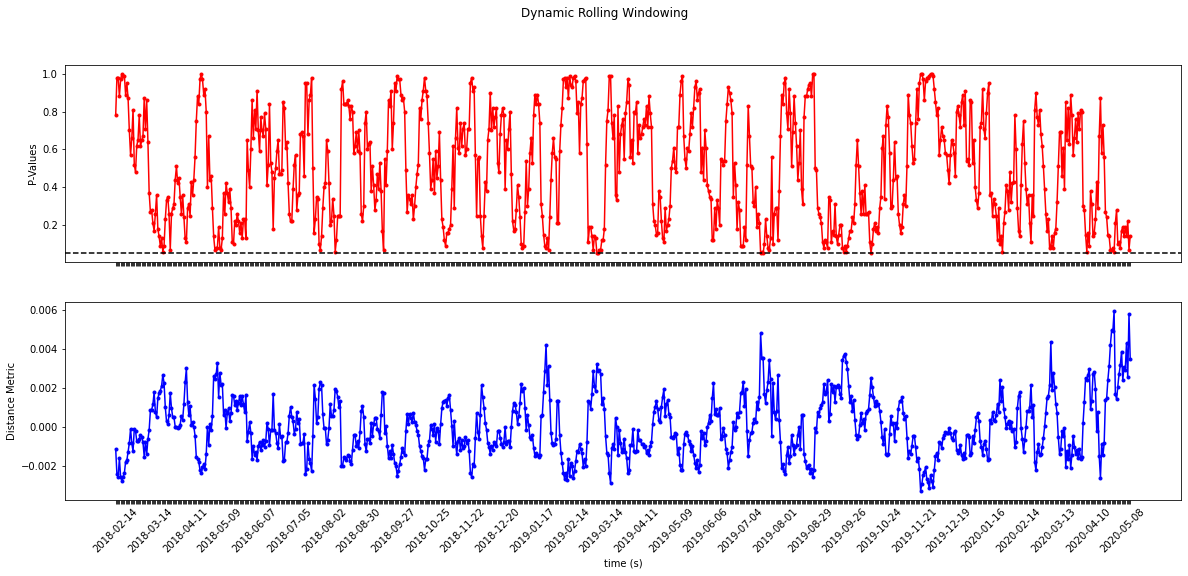

In [32]:
end = len(p_vals_test)
measure_dates_test_14d = [(datetime.datetime.strptime(date,"%Y-%m-%d")+datetime.timedelta(days=stat_window*2+lookup_window)).strftime("%Y-%m-%d") for date in measure_dates_test]
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,8))
fig.suptitle('Dynamic Rolling Windowing')

end = len(p_vals_test)
ax1.plot(measure_dates_test_14d[1:end], p_vals_test[1:end], '.-', color="red")
ax1.axhline(y=0.05, color='black', linestyle='--')
ax1.set_ylabel('P-Values')
ax1.set_xticklabels([])
        
ax2.plot(measure_dates_test_14d[1:end], dist_vals_test[1:end], '.-',color="blue")
ax2.set_xlabel('time (s)')
ax2.set_ylabel('Distance Metric')
ax2.tick_params(axis='x', labelrotation=45)
for index, label in enumerate(ax2.xaxis.get_ticklabels()):
    if index % 28 != 0:
        label.set_visible(False)

plt.show()

In [33]:
stat_window=14
lookup_window=60
dist_vals_test, p_vals_test = dynamic_rolling_window(stat_window, lookup_window, stride, num_timesteps, x_test_stream, threshold)

P-value below threshold, reset.
0 - 57 --> 117 - 131 	P-Value:  0.03999999910593033
P-value below threshold, reset.
44 - 113 --> 173 - 187 	P-Value:  0.03999999910593033
P-value below threshold, reset.
100 - 133 --> 193 - 207 	P-Value:  0.019999999552965164
P-value below threshold, reset.
120 - 134 --> 194 - 208 	P-Value:  0.029999999329447746
P-value below threshold, reset.
121 - 139 --> 199 - 213 	P-Value:  0.019999999552965164
P-value below threshold, reset.
126 - 152 --> 212 - 226 	P-Value:  0.009999999776482582
P-value below threshold, reset.
139 - 154 --> 214 - 228 	P-Value:  0.03999999910593033
P-value below threshold, reset.
141 - 247 --> 307 - 321 	P-Value:  0.029999999329447746
P-value below threshold, reset.
234 - 248 --> 308 - 322 	P-Value:  0.03999999910593033
P-value below threshold, reset.
235 - 249 --> 309 - 323 	P-Value:  0.009999999776482582
P-value below threshold, reset.
236 - 250 --> 310 - 324 	P-Value:  0.03999999910593033
P-value below threshold, reset.
237 - 251

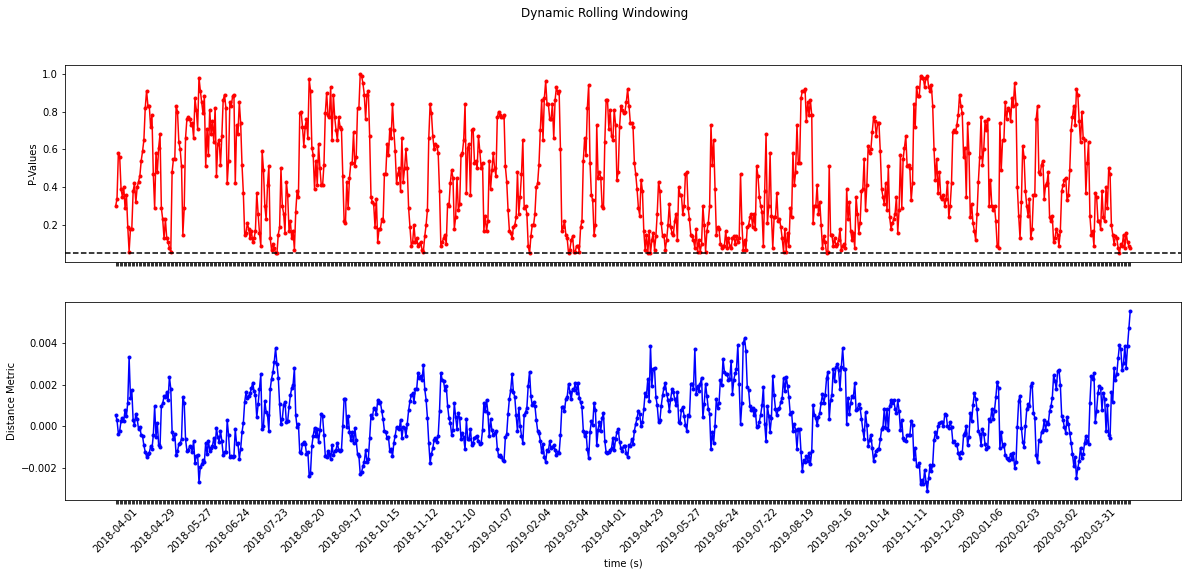

In [45]:
end = len(p_vals_test)
measure_dates_test_60d = [(datetime.datetime.strptime(date,"%Y-%m-%d")+datetime.timedelta(days=lookup_window+stat_window*2)).strftime("%Y-%m-%d") for date in measure_dates_test]
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,8))
fig.suptitle('Dynamic Rolling Windowing')

ax1.plot(measure_dates_test_60d[1:end], p_vals_test[1:end], '.-', color="red")
ax1.axhline(y=0.05, color='black', linestyle='--')
ax1.set_ylabel('P-Values')
ax1.set_xticklabels([])
        
ax2.plot(measure_dates_test_60d[1:end], dist_vals_test[1:end], '.-',color="blue")
ax2.set_xlabel('time (s)')
ax2.set_ylabel('Distance Metric')
ax2.tick_params(axis='x', labelrotation=45)
for index, label in enumerate(ax2.xaxis.get_ticklabels()):
    if index % 28 != 0:
        label.set_visible(False)

plt.show()